<a href="https://colab.research.google.com/github/LuanPCunha/TCC/blob/main/Copy_CNN_Rafa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Downloads e imports

In [ ]:
!pip install tensorflow
!pip install keras

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [84]:
import sklearn
import numpy as np
import pandas as pd
from numpy import loadtxt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras import layers
from keras.layers import Dropout, Conv1D, MaxPooling1D, Flatten, Dense, SpatialDropout1D, BatchNormalization
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import schedules, Adam, Adadelta, SGD, RMSprop, Adagrad, Adamax, Nadam, Ftrl # Estamos usando só o Nadam
from keras.models import Sequential
from keras.layers.embeddings import Embedding


from numpy.random import seed  
tf.random.set_seed(1)

In [85]:
def tokenize(tweets_list):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(tweets_list)
    return tokenizer.texts_to_sequences(tweets_list), tokenizer

In [86]:
def pad(text_tokenized, length=None):
    return pad_sequences(text_tokenized, maxlen=length, padding='post')

In [87]:
def preprocess(tweets_list, max_text_length):
    preprocess_tweets_list, tweets_list_tokenizer = tokenize(tweets_list)

    preprocess_tweets_list = pad(preprocess_tweets_list, length=max_text_length)

    return preprocess_tweets_list, tweets_list_tokenizer

In [88]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])

In [89]:
# Plot de Gráficos

def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('accuracy') 
  plt.xlabel('epoch')
  plt.show()
  
  
def plot_loss(history, miny=None):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.plot(epochs, loss)
  plt.plot(epochs, val_loss)
  if miny:
    plt.ylim(miny, 1.0)
  plt.legend(['train', 'test'], loc='upper left')
  plt.title('loss') 
  plt.xlabel('epoch')
  plt.show()

# Carrega base

In [90]:
# Base1 Com StopWords
PATH_BASE1_JUNTO_COM_DA_LEILA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1JuntaHateENotHateDaLeila_balanceada.csv"
#MATRIZ_CBOW_300_BASE_1 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base1JuntaHateENotHateDaLeila_balanceada_CBOW300.CSV", delimiter=',')

# Base2 Sem StopWords
PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA = "/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_maior4_menor25_limpissima_balanceada.csv"
#MATRIZ_CBOW_300_BASE_2_LEILA = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_maior4_menor25_limpissima_balanceada_CBOW300.CSV", delimiter=',')

PATH_BASE_1_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base1_classificada_balanceada.csv" #entrada

PATH_BASE_2_CLASSIFICADA_BALANCEADA = r"/content/drive/MyDrive/TCC/dados/processadas/balanceadas/Base2_classificada_balanceada.csv" #entrada
# MATRIZ_CBOW_300_BASE_2 = loadtxt("/content/drive/MyDrive/TCC/dados/word_embeddings/Matriz_Base2_classificada_balanceada_CBOW300.csv", delimiter=',') #saida

# Execução modelo

In [91]:
tweets = pd.read_csv(PATH_BASE2_LEILA_LIMPISSIMA_BALANCEADA, index_col=0)
text_column = tweets['text']
text_column

0                            ambiguinho eu estou com nojo
1                        menino do céu para que está feio
2       já pergunto a porra do trem já sabendo da vdd ...
3                                   sardella só faz merda
4                        foda se na real vou tratar igual
                              ...                        
4881    estou sem presidente por quatro anos nãomerepr...
4882    somos todos iguais braços dados ou não quem sa...
4883    que deus nos proteja e cuidem um do outro somo...
4884                         quem será que não sabe votar
4885         disse o cidadão que votou no gaucho de geral
Name: text, Length: 4886, dtype: object

In [92]:
# Pega a média de caracteres dos tweets de toda a base
max_text_length = int(text_column.apply(lambda x: len(str(x).split(' '))).max())
max_text_length

25

In [93]:
output_label = tweets['label']

input_data, text_tokenizer = preprocess(text_column, None)
    
text_vocab_size = len(text_tokenizer.word_index)
print("Vocabulary size:", text_vocab_size)

Vocabulary size: 9147


In [94]:
# parametros:
BATCH_SIZE = 3
EPOCHS =15
VAL_AND_TST_SIZE = 0.2
LEARN_RATE = 0.00005 
# ******
BETA_1 = 0.09
BETA_2 = 0.0999
EPSILON = 1e-07
# *****
EMBEDDING_DIMENSION = 300  
MAX_TEXT_SIZE = max_text_length 
VOCAB_SIZE = text_vocab_size

In [95]:
def optimize (learning_rate, beta_1, beta_2, epsilon):
  return Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon, name="Nadam")

In [96]:
# https://towardsdatascience.com/visualizing-how-filters-work-in-convolutional-neural-networks-cnns-7383bd84ad2c
# https://colab.research.google.com/drive/18ejmbJn9KVcqWJzOvAz84HxIpPMeTijU#scrollTo=Hjf_s9MrZky2

In [135]:
def create_cnn (vocab_size, embedding_dimen, max_text_size ):

  embedding_layer = Embedding(VOCAB_SIZE, EMBEDDING_DIMENSION, input_length=MAX_TEXT_SIZE)

  int_sequences_input = keras.Input(shape=(None,), dtype="int64")
  embedded_sequences = embedding_layer(int_sequences_input)
  x = layers.Conv1D(2,3, activation="relu")(embedded_sequences)
  # ******
  x = layers.Dense(100, activation="relu")(x)
  x = layers.Dropout(0.1)(x)
 
  x = layers.GlobalMaxPooling1D()(x)
  # x = layers.MaxPooling1D()(x)
  # x = layers.Conv1D(100, 3, activation="relu")(x)
  # x = layers.MaxPooling1D()(x)
  # x = layers.Conv1D(100, 3, activation="relu")(x)
  # x = SpatialDropout1D(0.1)(x)
  # x = BatchNormalization()(x)
  # *******
  preds = layers.Dense(2, activation="softmax")(x)
  model = keras.Model(int_sequences_input, preds)
  return model 
  

In [98]:
def train_model(input_data, output_label, embedding_dimen, batch_size, epochs, validation_and_test_size):
    
    X_train, X_test, y_train, y_test = train_test_split(input_data, output_label, test_size=validation_and_test_size)

    optimizer = optimize(LEARN_RATE, BETA_1, BETA_2, EPSILON)
    
    model = create_cnn(VOCAB_SIZE, EMBEDDING_DIMENSION, MAX_TEXT_SIZE)
    model.summary()
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy'])                                                                                                
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), validation_split = validation_and_test_size, verbose=2, use_multiprocessing=True)
    scores = model.evaluate(X_test, y_test, verbose=1)
    
    return history

In [136]:
# plot dos gráficos
history = train_model(input_data, output_label, EMBEDDING_DIMENSION, BATCH_SIZE, EPOCHS, VAL_AND_TST_SIZE)

Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_35 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_34 (Embedding)    (None, None, 300)         2744100   
                                                                 
 conv1d_47 (Conv1D)          (None, None, 2)           1802      
                                                                 
 dense_76 (Dense)            (None, None, 100)         300       
                                                                 
 dropout_43 (Dropout)        (None, None, 100)         0         
                                                                 
 global_max_pooling1d_34 (Gl  (None, 100)              0         
 obalMaxPooling1D)                                               
                                                          

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1042/1042 - 5s - loss: 0.6898 - accuracy: 0.6027 - val_loss: 0.6820 - val_accuracy: 0.6752 - 5s/epoch - 5ms/step
Epoch 2/15
1042/1042 - 4s - loss: 0.6497 - accuracy: 0.7025 - val_loss: 0.6206 - val_accuracy: 0.6726 - 4s/epoch - 4ms/step
Epoch 3/15
1042/1042 - 4s - loss: 0.5736 - accuracy: 0.7150 - val_loss: 0.5552 - val_accuracy: 0.7110 - 4s/epoch - 4ms/step
Epoch 4/15
1042/1042 - 4s - loss: 0.5161 - accuracy: 0.7246 - val_loss: 0.5208 - val_accuracy: 0.7123 - 4s/epoch - 4ms/step
Epoch 5/15
1042/1042 - 4s - loss: 0.4838 - accuracy: 0.7652 - val_loss: 0.4993 - val_accuracy: 0.7570 - 4s/epoch - 4ms/step
Epoch 6/15
1042/1042 - 4s - loss: 0.4588 - accuracy: 0.7857 - val_loss: 0.4764 - val_accuracy: 0.7673 - 4s/epoch - 4ms/step
Epoch 7/15
1042/1042 - 4s - loss: 0.4288 - accuracy: 0.8017 - val_loss: 0.4517 - val_accuracy: 0.7890 - 4s/epoch - 4ms/step
Epoch 8/15
1042/1042 - 4s - loss: 0.3957 - accuracy: 0.8221 - val_loss: 0.4264 - val_accuracy: 0.8082 - 4s/epoch - 4ms/step
Epoch 9/15
1042/104

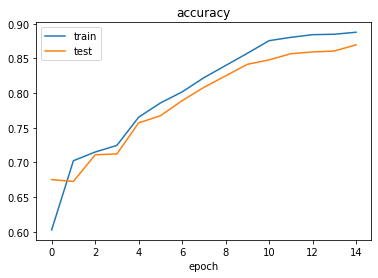

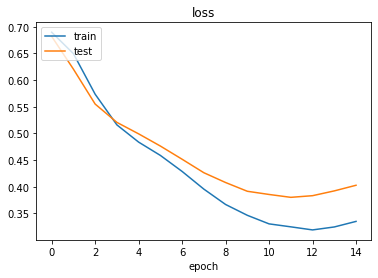

In [137]:
plot_accuracy(history)
plot_loss(history)

In [101]:
optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam")

model = Sequential()
model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 

model.add(Conv1D(100, 3, activation="relu"))
model.add(Conv1D(100, 3, activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling1D())
model.add(Conv1D(100, 3, activation="relu"))
model.add(Conv1D(100, 3, activation="relu"))
model.add(Dropout(0.3))
model.add(MaxPooling1D())

model.add(Flatten())
model.add(Dense(64, activation='softmax'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']) 
model.summary()

# Fit the model                                                                                               #val split
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)

NameError: ignored

In [ ]:
# plot dos gráficos
plot_accuracy(history)
plot_loss(history)

In [ ]:
# lr_schedule = schedules.ExponentialDecay(
#     initial_learning_rate=lr,
#     decay_steps=10000,
#     decay_rate=0.9)

# https://keras.io/api/optimizers/
# https://keras.io/examples/nlp/pretrained_word_embeddings/
# https://keras.io/api/layers/base_layer/#layer-class

# optimizer = Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name="Adadelta") 
#optimizer = SGD(learning_rate=0.01, momentum=0.0, nesterov=True, name="SGD")
#optimizer = RMSprop(learning_rate=0.001,rho=0.9,momentum=0.0,epsilon=1e-07,centered=True,name="RMSprop")
#optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True, name="Adam")
#optimizer = Adagrad(learning_rate=0.001, initial_accumulator_value=0.1, epsilon=1e-07, name="Adagrad")
#optimizer = Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Adamax")
optimizer = Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam") # 96% Embedding Treinado /
#optimizer = Ftrl(learning_rate=0.001, learning_rate_power=-0.5, initial_accumulator_value=0.1, l1_regularization_strength=0.1, l2_regularization_strength=0.1, l2_shrinkage_regularization_strength=0.001, beta=0.0001, name="Ftrl")

# # defininindo a camada de embedding utilizando a matriz
# embedding_layer = Embedding(input_dim=MATRIZ_CBOW_300_BASE_2.shape[0],
#                             output_dim=MATRIZ_CBOW_300_BASE_2.shape[1],
#                             # weights=[MATRIZ_CBOW_300_BASE_2],
#                             embeddings_initializer=keras.initializers.Constant(MATRIZ_CBOW_300_BASE_2),
#                             input_length=tam_max,
#                             trainable=False)


model = Sequential()
# primeira camada se trata do embedding. 
# model.add(embedding_layer)
model.add(Embedding(tam_vocab, embedding_dimen, input_length=tam_max)) 


# camada convolucional
# filtros referentes ao output dessa camada,
# tamanho nucleo = 3, se tratando apenas de uma dimensão (conv1d)
# padding 'valid' = sem padding
# função de ativação = relu
model.add(Dropout(drp))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Dropout(drp))
model.add(MaxPooling1D())


# camada convolucional                         'valid|same'
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Conv1D(filtros, kernel_size, padding='same', activation='relu', strides=1))
model.add(Dropout(drp))
model.add(MaxPooling1D())


# nivela o output para utilização na camada densa
model.add(Flatten())

# regularização por dropout
model.add(Dense(2, activation='softmax'))


model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=optimizer, metrics=['accuracy']) 
model.summary()

# Fit the model                                                                                               #val split
history = model.fit(X_train, y_train, batch_size=batchsize, epochs=epochs,validation_data=(X_test, y_test), validation_split = 0.3, verbose=2)

# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# plot dos gráficos
plot_accuracy(history)
plot_loss(history)

In [ ]:
tf.keras.utils.plot_model(model, to_file='/meuarquivo.png', show_shapes=True)